# Time series forecasting Bitcoin Price Prediction


### Importing time series data with pandas
This data contains 4707 rows and there are two columns such as Start, which is date, and Close, which is bitcoin close price. We've collected the historical price of Bitcoin from 2012 to 2024(November).

In [1]:
# Import with pandas 
import pandas as pd
from datetime import datetime
# Parse dates and set date column to index
df = pd.read_csv(r'C:\Users\ASUS\Desktop\Data Ethics and Privacy\BTC_Project\DataPreprocessing\data.csv') 

In [2]:
# Sort the DataFrame by 'Start' date
df = df.sort_values(by='Start', ascending=True)

# Reset the index after sorting
df = df.reset_index(drop=True)

In [3]:
df.head()

,Start,Close
0,2012-01-01,5.2677
1,2012-01-02,5.2168
2,2012-01-03,4.8808
3,2012-01-04,5.5738
4,2012-01-05,6.9476


In [4]:
# Convert the 'Start' column to datetime format and extract the date array for Bitcoin
df['Start'] = pd.to_datetime(df['Start'])
timesteps = df['Start'].to_numpy()  # Convert 'Start' column to a NumPy array of timestamps
prices = df["Close"].to_numpy()  # Extract the 'Close' column as a NumPy array of Bitcoin prices

In [5]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(3765, 942, 3765, 942)

## Modelling Experiments

We can build almost any kind of model for our problem as long as the data inputs and outputs are formatted correctly.

However, just because we *can* build *almost any* kind of model, doesn't mean it'll perform well/should be used in a production setting.

We'll see what this means as we build and evaluate models throughout.

Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, **horizon** and **window**. 
  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**

## Model 0: Naïve forecast (baseline)

As usual, let's start with a baseline.

One of the most common baseline models for time series forecasting, the naïve model (also called the [naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$ 

In English: 
> The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (the previous timestep).

Sound simple?

Maybe not.

In an open system (like a stock market or crypto market), you'll often find beating the naïve forecast with *any* kind of model is quite hard.

In [6]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10 

(array([39419.5301    , 39479.99697027, 40475.27521136, 38026.7462556 ,
        39248.43928178, 39749.9386    , 38592.00441699, 37660.45292214,
        38467.094     , 38503.90959019]),
 array([76615.99, 80409.97, 88627.98, 88164.77, 90300.02, 87347.45,
        90949.94, 90543.67, 89763.59, 90549.34]))

The naive forecast looks like it's following the data well. 

Let's zoom in to take a better look.

We can do so by creating an offset value and passing it to the `start` parameter of our `plot_time_series()` function.

In [7]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

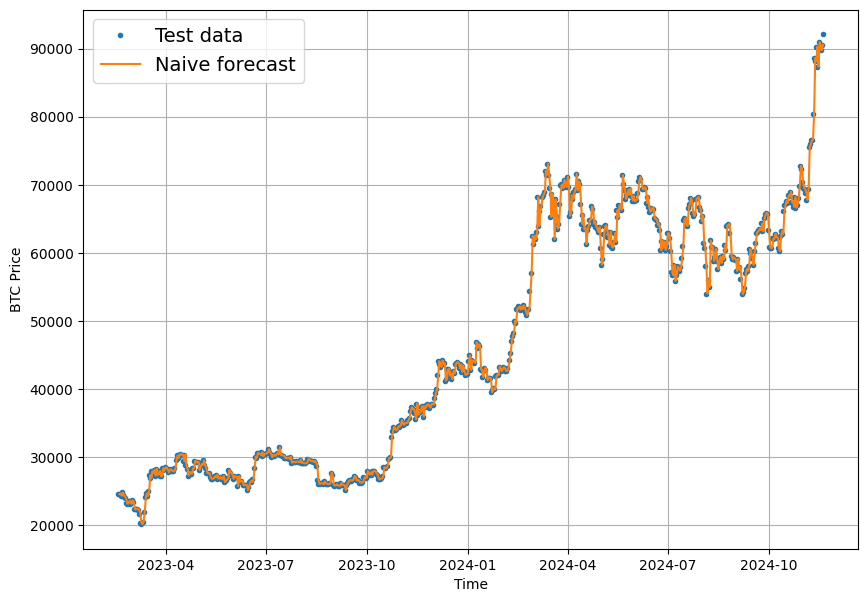

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

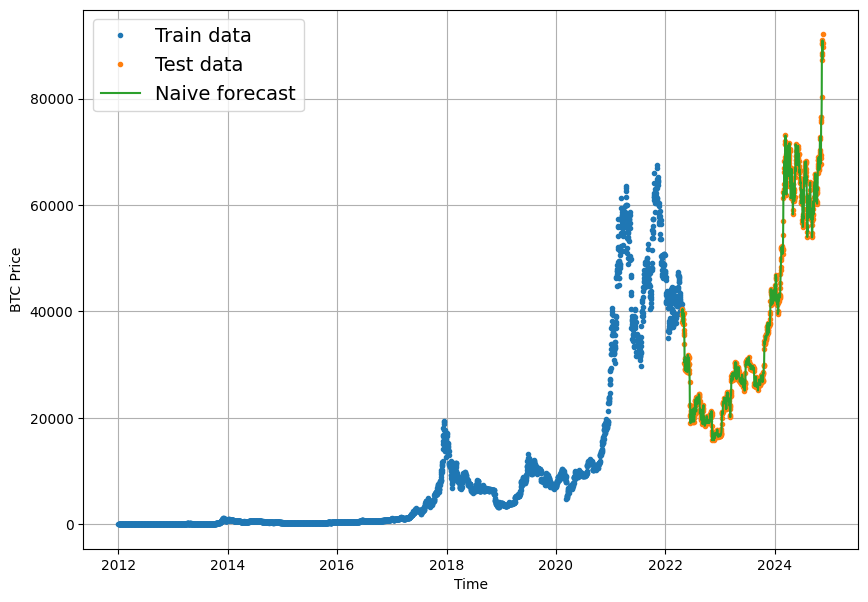

In [9]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

### Evaluating a Time Series Model

Time series forecasting aims to predict a value, such as Bitcoin's price, which is a regression problem. Evaluating how well our model's predictions (`y_pred`) match the actual values (`y_true`) is crucial.

#### Key Evaluation Metrics:

- **Scale-dependent errors**:
  These metrics are used when comparing time series values that are on the same scale (e.g., Bitcoin prices in USD).
  - **MAE (Mean Absolute Error)**: Measures the average magnitude of errors. Lower values indicate better forecasts.
  - **RMSE (Root Mean Squared Error)**: Similar to MAE but gives more weight to larger errors.

- **Percentage errors**:
  These metrics are unitless and allow for comparisons across datasets with different scales.
  - **MAPE (Mean Absolute Percentage Error)**: Commonly used but can fail if actual values are zero.
  - **sMAPE (Symmetric MAPE)**: A variation of MAPE, but not recommended for general use.

- **Scaled errors**:
  These provide a way to compare forecast performance across different time series.
  - **MASE (Mean Absolute Scaled Error)**: Measures the performance relative to a naive forecast (previous value). A MASE less than 1 means the model performs better than the naive forecast.

#### Choosing the Right Metric:
While there are many metrics available, **MAE** is often a good starting point due to its simplicity and ease of interpretation.

By using these metrics, it can assess the accuracy of different models and make informed decisions on their performance. 

The following TensorFlow functions help in calculating these metrics for model.

In [10]:
# Let's get TensorFlow! 
import tensorflow as tf

In [11]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data).
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))  # Seasonality is 1 day (shifting by 1)

    return mae / mae_naive_no_season

In [12]:
def evaluate_preds(y_true, y_pred):
    # Ensure float32 for metric calculations
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))  # Using manual MAE calculation
    mse = tf.reduce_mean(tf.square(y_true - y_pred))  # Squared error for MSE
    rmse = tf.sqrt(mse)  # Proper RMSE calculation
    mape = tf.reduce_mean(tf.abs((y_true - y_pred) / y_true))  # Custom MAPE calculation
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
        "mase": mase.numpy()
    }

In [13]:
# Assuming y_test and naive_forecast are properly defined
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 742.4181,
 'mse': 1421134.2,
 'rmse': 1192.1134,
 'mape': 0.018941278,
 'mase': 0.99902374}

In [14]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

38447.278005816166

## Format Data Part 2: Windowing dataset

Windowing is a method to turn a time series dataset into **supervised learning problem**. 

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like:

In [15]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

Now we'll write a function to take in an array and turn it into a window and horizon.

In [16]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [17]:
# # Test out the window labelling function
# test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
# print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

In [18]:
# Create function to view NumPy arrays as windows 
import numpy as np

def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [19]:
# Print our windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(4700, 4700)

In [20]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [5.2677 5.2168 4.8808 5.5738 6.9476 6.6969 6.81  ] -> Label: [7.1136]
Window: [5.2168 4.8808 5.5738 6.9476 6.6969 6.81   7.1136] -> Label: [6.3257]
Window: [4.8808 5.5738 6.9476 6.6969 6.81   7.1136 6.3257] -> Label: [6.36]


In [21]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [80409.97 88627.98 88164.77 90300.02 87347.45 90949.94 90543.67] -> Label: [89763.59]
Window: [88627.98 88164.77 90300.02 87347.45 90949.94 90543.67 89763.59] -> Label: [90549.34]
Window: [88164.77 90300.02 87347.45 90949.94 90543.67 89763.59 90549.34] -> Label: [92119.47]


### Converting windows into training and test sets 

Although we could have applied windowing to our existing training and test sets, the nature of windowing (which often requires an offset at certain points in the data) means it typically works better to first apply windowing to the entire dataset and then divide it into training and test sets.

Now, let's create a function that accepts the complete sets of windows and their labels and splits them into training and test sets.

In [22]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  This splits the full windows and labels into training and test sets and then outputs the lengths of each.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

Let's take a look at our training and test datasets after applying windowing.

In [23]:
# This returns the number of windows and labels in the training and test sets after the split.
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3760, 940, 3760, 940)

In [24]:
# Verify if they are the same (considering horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

The `ModelCheckpoint` callback will track the model's performance during training and save the best version to a file by setting `save_best_only=True`. 

This allows us to reload the best performing configuration from the file when evaluating the model.

In [25]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  os.makedirs(save_path, exist_ok=True)  # Create the directory if it doesn't exist
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name + ".keras"), # create filepath to save model
                                            monitor="val_loss",
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model: RNN (LSTM)

        Long Short-Term Memory Networks (LSTMs) each LSTM cell has three gates:

        Input Gate: Controls how much new information should be added to the cell state.

        Forget Gate: Decides what past information should be discarded.

        Output Gate: Regulates what information should be output at the current step.

This selective memory enables LSTMs to handle long-term dependencies, making them ideal for tasks where earlier context is critical.

    This model utilizes an [LSTM cell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) within an RNN to predict Bitcoin prices.

The key step in using LSTM is ensuring our data is correctly shaped. The input to the [`tf.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layer must have dimensions `[batch, timesteps, feature]`.

In this model, the `batch` dimension is handled automatically, but our data currently only includes the `feature` dimension (with `WINDOW_SIZE` as the number of timesteps).

We adjust the data shape by feeding it through a `tf.keras.layers.Lambda()` layer to reshape it properly for the LSTM input.

### Model Architecture

- **Input Layer**: Accepts data of shape `(WINDOW_SIZE, 1)`, where `1` is the feature (e.g., Bitcoin price).
- **LSTM Layer**: Contains 128 units with 'relu' activation to capture temporal dependencies.
- **Dense Output Layer**: Predicts the value(s) at the desired horizon (`HORIZON`).
- **Compilation**: The model is compiled with Mean Absolute Error (MAE) loss and Adam optimizer.
- **Training**: The model is trained for 1000 epochs with a batch size of 128, using validation data for early stopping.


In [27]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import layers 

# Custom callback to print the performance at each epoch
class PrintEpochPerformance(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}: Loss = {logs['loss']:.4f}, Val_loss = {logs['val_loss']:.4f}")

# Now, build the model as before
inputs = layers.Input(shape=(WINDOW_SIZE, 1))  # input shape with 1 feature per timestep
x = layers.LSTM(128, activation="relu")(inputs)  # LSTM layer
output = layers.Dense(HORIZON)(x)  # Output layer with horizon of 1

# Define the model
model_lstm = tf.keras.Model(inputs=inputs, outputs=output, name="model_lstm")

# Compile the model with Huber Loss
model_lstm.compile(
    loss=tf.keras.losses.Huber(),  # Changed from MAE to Huber Loss
    optimizer=tf.keras.optimizers.Adam()
)

# Fit the model
model_lstm.fit(
    train_windows,  # training data
    train_labels,   # target values
    epochs=300,
    verbose=0,      # Set to 0 to prevent default logging
    batch_size=32,
    validation_data=(test_windows, test_labels),
    callbacks=[
        create_model_checkpoint(model_name=model_lstm.name),  # Save the best model
        PrintEpochPerformance()  # Add the custom callback to print performance
    ]
)

Epoch 1: Loss = 1648.9852, Val_loss = 1261.8253
Epoch 2: Loss = 484.8856, Val_loss = 1475.8282
Epoch 3: Loss = 432.5181, Val_loss = 1575.2289
Epoch 4: Loss = 424.0317, Val_loss = 1266.5553
Epoch 5: Loss = 478.3507, Val_loss = 1346.8427
Epoch 6: Loss = 414.9184, Val_loss = 1427.5509
Epoch 7: Loss = 414.5915, Val_loss = 1180.8397
Epoch 8: Loss = 393.1370, Val_loss = 1304.7062
Epoch 9: Loss = 386.2319, Val_loss = 1595.0872
Epoch 10: Loss = 388.6632, Val_loss = 1153.9817
Epoch 11: Loss = 364.6060, Val_loss = 1517.0717
Epoch 12: Loss = 403.9923, Val_loss = 1225.9429
Epoch 13: Loss = 351.5469, Val_loss = 1140.2592
Epoch 14: Loss = 346.3078, Val_loss = 1077.3156
Epoch 15: Loss = 345.4828, Val_loss = 1715.9354
Epoch 16: Loss = 364.9206, Val_loss = 1172.2726
Epoch 17: Loss = 351.8128, Val_loss = 955.4656
Epoch 18: Loss = 338.9217, Val_loss = 919.1953
Epoch 19: Loss = 362.3295, Val_loss = 1035.4170
Epoch 20: Loss = 324.5367, Val_loss = 916.2656
Epoch 21: Loss = 326.9810, Val_loss = 873.4791
Epoc

In [28]:
# Evaluate LSTM model on the test data 
model_lstm.evaluate(test_windows, test_labels)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 619.9389 


746.8955688476562

## Making projects with this model(on the test dataset)

To make "forecasts" on the test dataset (these won't be actual forecasts are into the future)

1. Take in a train model 
2. Takes in some input data (same formatted as data the model was trained on)
3. Passes the input data to model's predict() method
4.Returns the predictions

In [29]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [30]:
# Make predictions with our LSTM model on the test dataset and view the results
model_lstm_preds = make_preds(model_lstm, test_windows)
model_lstm_preds[:10]

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([39589.957, 40549.848, 38223.137, 39341.902, 39824.71 , 38748.125,
       37821.746, 38551.504, 38603.105, 37873.965], dtype=float32)>

In [31]:
# Evaluate preds many layer
model_lstm_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_lstm_preds)
model_lstm_results 

{'mae': 747.3955,
 'mse': 1418928.2,
 'rmse': 1191.1877,
 'mape': 0.019187992,
 'mase': 1.0060852}

And of course, no evaluation would be finished without visualizing the results. :( here we go JKJ

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


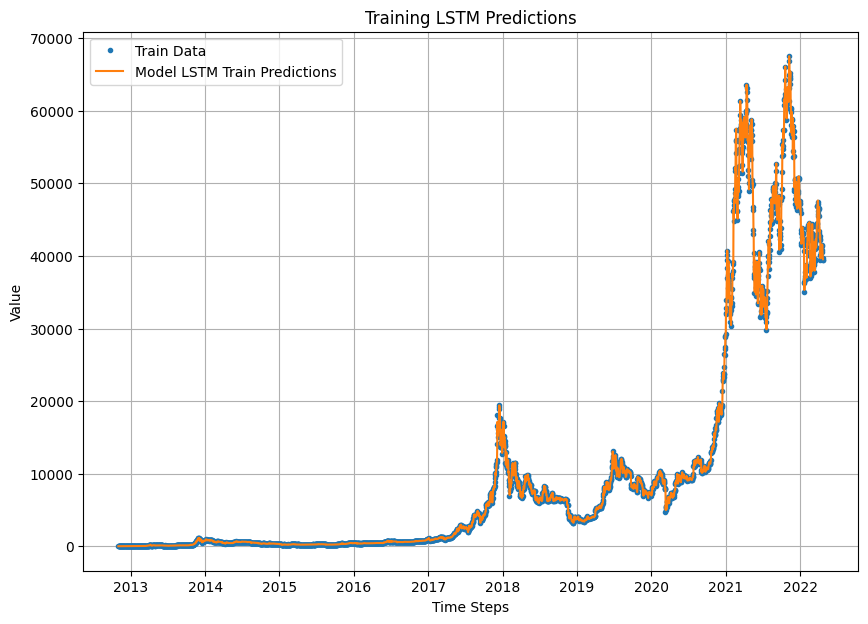

In [32]:
# Your LSTM model predictions
offset = 300  # Adjust this based on your data
plt.figure(figsize=(10, 7))

# Make predictions for training data
model_lstm_train_preds = make_preds(model_lstm, train_windows)  # Predictions for the training data

# Plot the training data and predictions
plot_time_series(timesteps=X_train[-len(train_windows):], values=train_labels, start=offset, label="Train Data")
plot_time_series(timesteps=X_train[-len(train_windows):], values=model_lstm_train_preds, start=offset, format="-", label="Model LSTM Train Predictions")

# Add labels and legend
plt.title("Training LSTM Predictions")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.show()


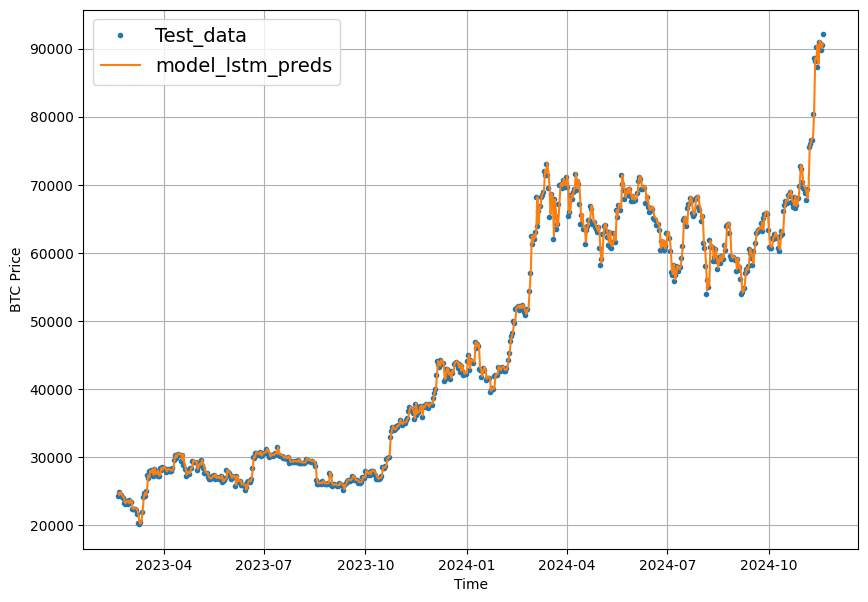

In [33]:
# Our lstm model predictions
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_lstm_preds, start=offset, format="-", label="model_lstm_preds")

In [33]:
model_lstm.summary()

Model: "model_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,069 (781.52 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 133,380 (521.02 KB)

In [34]:
# from tensorflow.keras.models import load_model

# model_path = r'C:\Users\ASUS\Desktop\Data Ethics and Privacy\BTC_Project\Model\model_experiments\model_lstm.keras'
# model = load_model(model_path)


### XGBoost Model

I feel a bit lazy now, so let’s let ChatGPT handle XGBoost for me. By the way, I need to copy my LSTM model architecture and paste it into ChatGPT... hmm. Love is singular! But my heart is like RNNs, many-to-many—10 at once, with both sequential and horizon values. Love is constant, whether in the present or future, just like how I love you at an equal percentage. 

In [35]:
import xgboost as xgb

# Custom callback to print the performance at each epoch
class PrintEpochPerformance(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}: Loss = {logs['loss']:.4f}, Val_loss = {logs['val_loss']:.4f}")

In [36]:
# Function to implement a ModelCheckpoint-like mechanism for XGBoost
def create_model_checkpoint(model_name, save_path="model_experiments"):
    os.makedirs(save_path, exist_ok=True)  # Ensure save directory exists
    return os.path.join(save_path, model_name + ".json")  # Save as .json for XGBoost

In [37]:
# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(train_windows, label=train_labels)
dtest = xgb.DMatrix(test_windows, label=test_labels)

In [38]:
params = {
    "objective": "reg:squarederror",
    "eval_metric": "mae",  # Can also try 'rmse'
    "max_depth": 6,  # Start with 6, tune within 4-10
    "eta": 0.05,  # Slightly increased learning rate
    "subsample": 0.8,  # Adjusted for diversity in rows
    "colsample_bytree": 0.8,  # Adjusted for diversity in features
    "lambda": 1.0,  # L2 regularization
    "alpha": 0.1,  # L1 regularization
    "seed": 42
}


In [39]:
# Custom training loop for XGBoost with callbacks
model_name = "xgboost_model"
checkpoint_path = create_model_checkpoint(model_name)

num_boost_round = 300  # Matches LSTM epochs
early_stopping_rounds = 10  # Early stopping patience
evals = [(dtrain, "train"), (dtest, "val")]

In [40]:
# Initialize variables for tracking the best model
best_val_loss = float("inf")
best_model = None

In [41]:
from sklearn.metrics import mean_absolute_error

In [42]:
# Training loop
for epoch in range(num_boost_round):
    # Train for one round
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=epoch + 1,
        evals=evals,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=False
    )

    # Calculate losses
    train_pred = model.predict(dtrain)
    val_pred = model.predict(dtest)
    train_loss = mean_absolute_error(train_labels, train_pred)
    val_loss = mean_absolute_error(test_labels, val_pred)

    # Custom callback to print performance
    logs = {"loss": train_loss, "val_loss": val_loss}
    PrintEpochPerformance().on_epoch_end(epoch, logs)

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        model.save_model(checkpoint_path)

print("Training complete. Best model saved.") 


Epoch 1: Loss = 9719.6779, Val_loss = 28108.1014
Epoch 2: Loss = 9238.5984, Val_loss = 26820.4837
Epoch 3: Loss = 8780.7276, Val_loss = 25516.3681
Epoch 4: Loss = 8345.1206, Val_loss = 24300.4118
Epoch 5: Loss = 7932.4704, Val_loss = 23150.0066
Epoch 6: Loss = 7539.1834, Val_loss = 22024.5136
Epoch 7: Loss = 7166.1503, Val_loss = 20981.2923
Epoch 8: Loss = 6811.1740, Val_loss = 20008.9966
Epoch 9: Loss = 6474.4865, Val_loss = 19071.8989
Epoch 10: Loss = 6152.6512, Val_loss = 18194.6118
Epoch 11: Loss = 5847.9261, Val_loss = 17319.3245
Epoch 12: Loss = 5558.6902, Val_loss = 16507.7934
Epoch 13: Loss = 5284.4614, Val_loss = 15746.7440
Epoch 14: Loss = 5023.1764, Val_loss = 15043.7684
Epoch 15: Loss = 4774.0729, Val_loss = 14370.9591
Epoch 16: Loss = 4538.5607, Val_loss = 13727.6473
Epoch 17: Loss = 4314.3368, Val_loss = 13080.0716
Epoch 18: Loss = 4101.2600, Val_loss = 12471.5314
Epoch 19: Loss = 3899.1382, Val_loss = 11898.9143
Epoch 20: Loss = 3707.5173, Val_loss = 11361.6286
Epoch 21:

In [43]:
# Load the best model (if needed)
loaded_model = xgb.Booster()
loaded_model.load_model(checkpoint_path)

In [44]:
# Predict on the test data
predictions = loaded_model.predict(dtest)
print(f"Test MAE: {mean_absolute_error(test_labels, predictions):.4f}")

Test MAE: 2107.5342


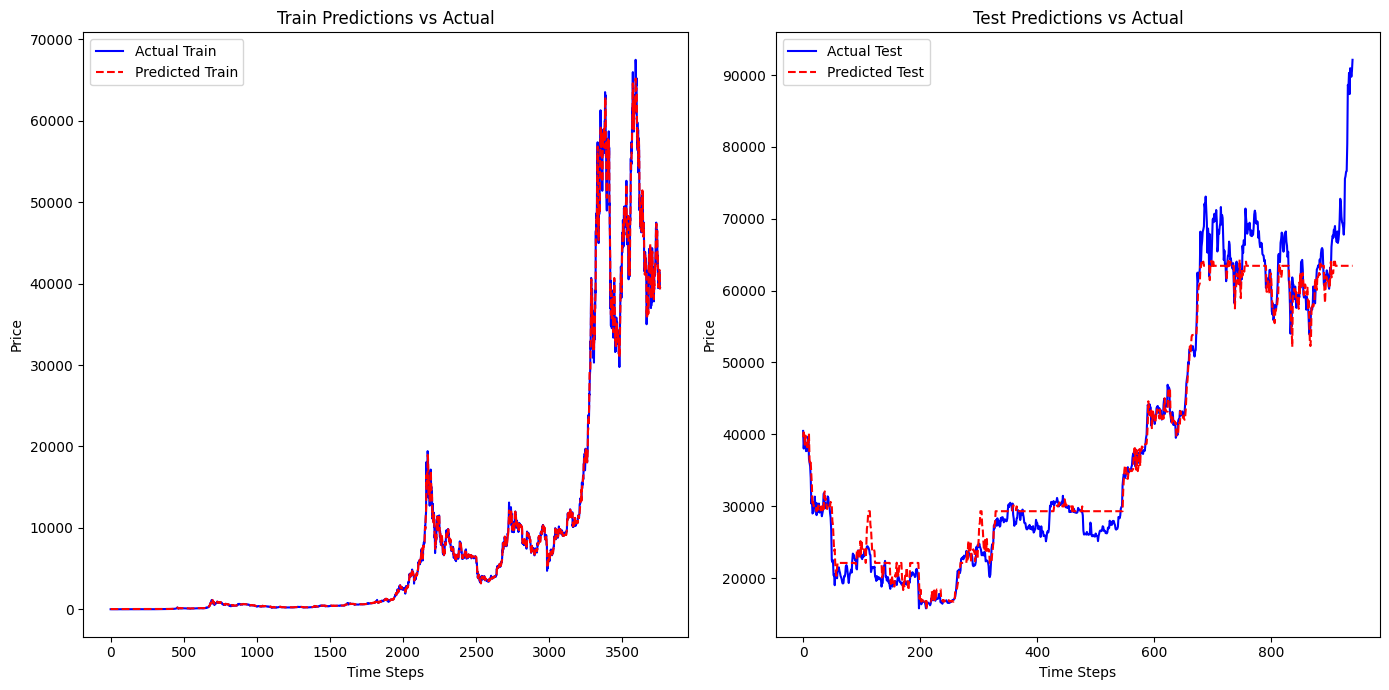

In [45]:
import matplotlib.pyplot as plt 

# Plot predictions vs actuals for train and test datasets
def plot_predictions(train_labels, train_predictions, test_labels, test_predictions):
    plt.figure(figsize=(14, 7))

    # Plot training data predictions
    plt.subplot(1, 2, 1)
    plt.plot(train_labels, label="Actual Train", color="blue")
    plt.plot(train_predictions, label="Predicted Train", color="red", linestyle="dashed")
    plt.title("Train Predictions vs Actual")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.legend()

    # Plot testing data predictions
    plt.subplot(1, 2, 2)
    plt.plot(test_labels, label="Actual Test", color="blue")
    plt.plot(test_predictions, label="Predicted Test", color="red", linestyle="dashed")
    plt.title("Test Predictions vs Actual")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Generate predictions
train_predictions = loaded_model.predict(dtrain)
test_predictions = loaded_model.predict(dtest)

# Plot the results
plot_predictions(train_labels, train_predictions, test_labels, test_predictions)


In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

# Load the saved model
model = load_model('C:\\Users\\ASUS\\Desktop\\Data Ethics and Privacy\\BTC_Project\\Model\\model_experiments\\model_lstm.keras')  # Replace with your saved model's path

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

print("Model architecture saved as 'model_architecture.png'")


Model architecture saved as 'model_architecture.png'


<Figure size 3000x2500 with 0 Axes>

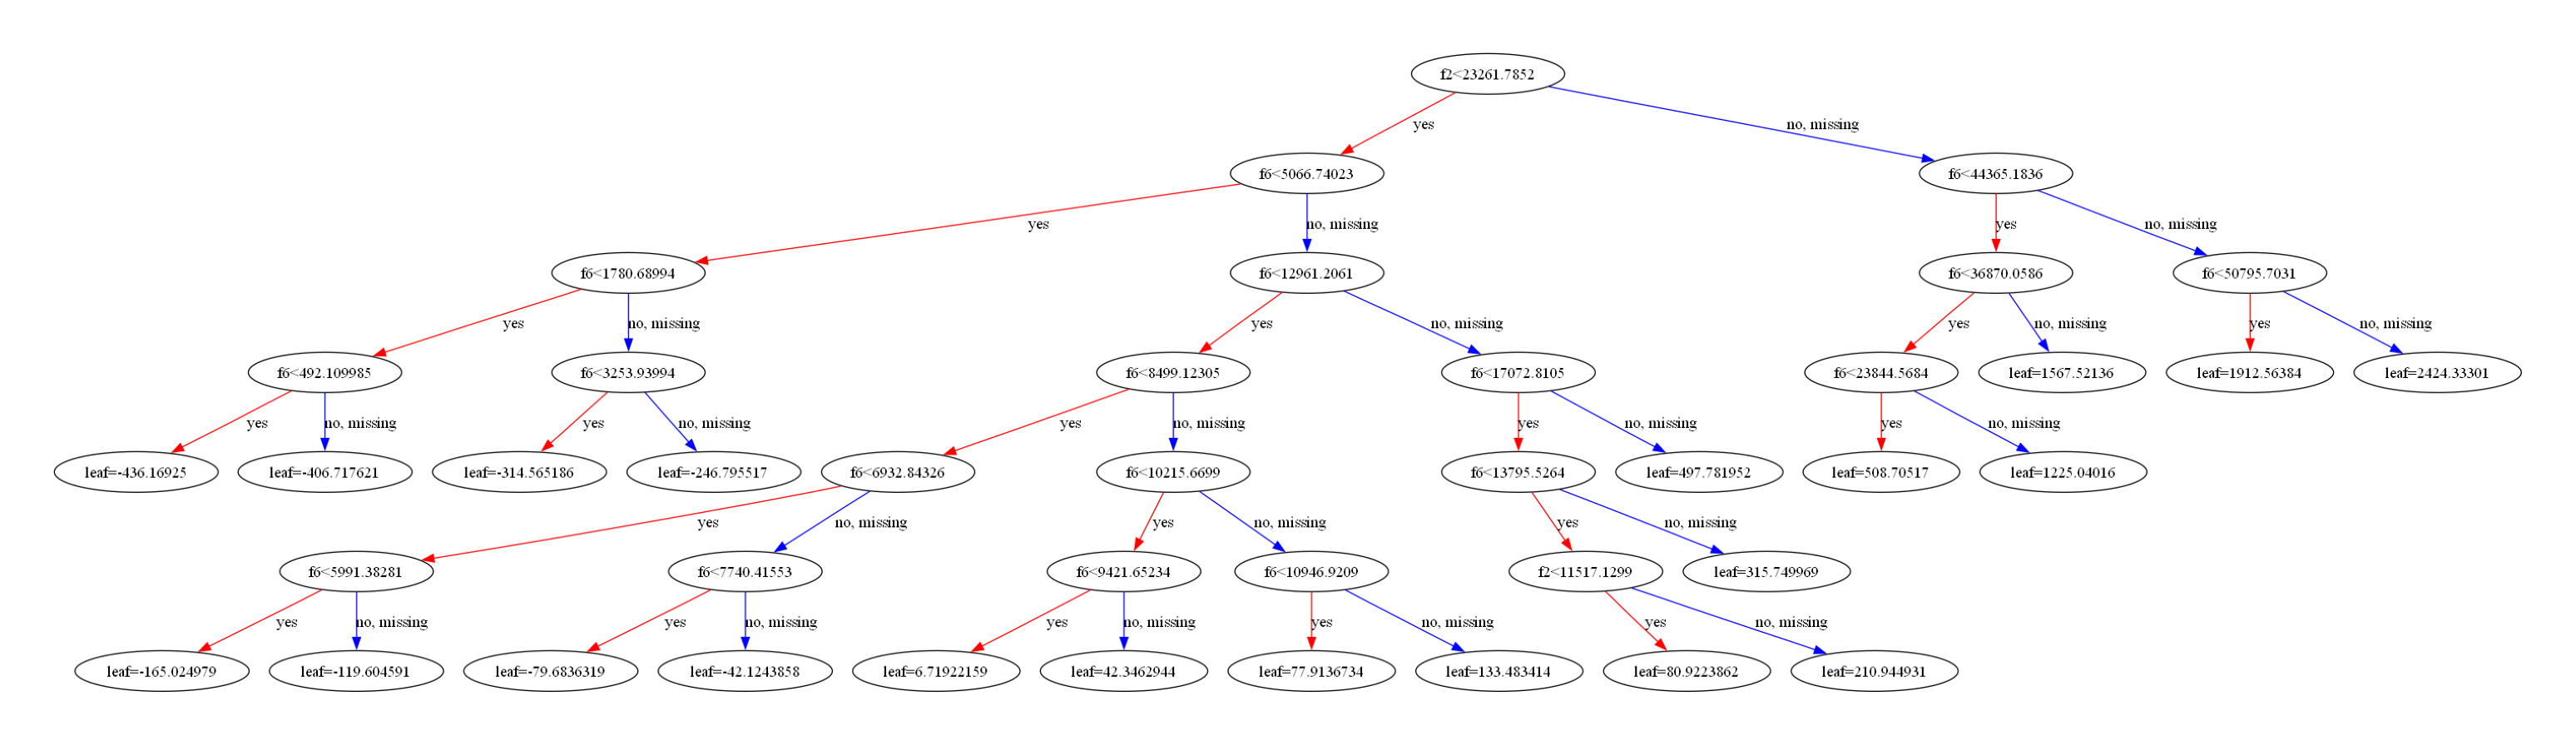

In [3]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Load the XGBoost model from the JSON file
model = xgb.Booster()
model.load_model('C:\\Users\\ASUS\\Desktop\\Data Ethics and Privacy\\BTC_Project\\Model\\model_experiments\\xgboost_model.json')

# Plot the first tree in the model with much higher resolution and a larger figure size
plt.figure(figsize=(30, 25))  # Make the figure even larger for more details
xgb.plot_tree(model, num_trees=0)
plt.gcf().set_dpi(600)  # Set DPI to 600 for extremely high resolution
plt.show()


In [4]:
import xgboost as xgb
import graphviz

# Load the XGBoost model from the JSON file
model = xgb.Booster()
model.load_model('C:\\Users\\ASUS\\Desktop\\Data Ethics and Privacy\\BTC_Project\\Model\\model_experiments\\xgboost_model.json')

# Convert the first tree to Graphviz format
graph = xgb.to_graphviz(model, num_trees=0)

# Render and save the tree as a PNG image
graph.render('xgboost_tree', format='png', cleanup=True)

# Show the plot (optional)
graph.view()

'xgboost_tree.pdf'

In [49]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load the XGBoost model from the JSON file
loaded_model = xgb.Booster()
loaded_model.load_model('C:\\Users\\ASUS\\Desktop\\Data Ethics and Privacy\\BTC_Project\\Model\\model_experiments\\xgboost_model.json')

# Assuming you already have dtrain (XGBoost DMatrix for training data) and dtest (for test data)
# Generate predictions
train_predictions = loaded_model.predict(dtrain)
test_predictions = loaded_model.predict(dtest)

# Get the true labels from your dtest and dtrain DMatrix
train_labels = dtrain.get_label()
test_labels = dtest.get_label()

# Compute MAE (Mean Absolute Error) for train and test datasets
train_mae = mean_absolute_error(train_labels, train_predictions)
test_mae = mean_absolute_error(test_labels, test_predictions)

# Compute MSE (Mean Squared Error)
train_mse = mean_squared_error(train_labels, train_predictions)
test_mse = mean_squared_error(test_labels, test_predictions)

# Compute RMSE (Root Mean Squared Error)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Compute MAPE (Mean Absolute Percentage Error)
train_mape = np.mean(np.abs((train_labels - train_predictions) / train_labels))  # Avoid division by zero
test_mape = np.mean(np.abs((test_labels - test_predictions) / test_labels))

# Compute MASE (Mean Absolute Scaled Error)
# Using naive prediction based on the previous step in the time series
train_naive_pred = np.roll(train_labels, 1)
train_naive_pred[0] = np.nan  # Handle the first element as NaN
train_mase = np.mean(np.abs(train_labels - train_predictions)) / np.nanmean(np.abs(train_labels - train_naive_pred))

test_naive_pred = np.roll(test_labels, 1)
test_naive_pred[0] = np.nan  # Handle the first element as NaN
test_mase = np.mean(np.abs(test_labels - test_predictions)) / np.nanmean(np.abs(test_labels - test_naive_pred))

# Print all metrics
print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MAPE: {test_mape}")
print(f"Test MASE: {test_mase}")


Test MAE: 2107.534423828125
Test MSE: 13777630.0
Test RMSE: 3711.822998046875
Test MAPE: 0.054759882390499115
Test MASE: 2.8369972705841064
